# ai-interface 使用示例

## 1 包导入

In [1]:
import ai_interface
from ai_interface import BaseLLM
from ai_interface import TemplateLLM


## 2 QA示例
llm.call 方法接受几乎所有 OpenAI 的可选参数。默认使用 `gpt-4o` 模型，如需使用其他模型，可在调用时通过 `model` 参数指定。  
可选模型详见聚合 API 网站，这里以 [DMXAPI](https://www.dmxapi.cn/pricing) 为例。

### 2.1 单次问讯

In [2]:
llm = BaseLLM()
q = "Who is the president of the United States?"
llm.call(
    messages=[{'role': 'user', 'content': q}],
    response_format='text',
)
llm.print_history()


===================================== 👤 =====================================
Who is the president of the United States?

===================================== 🤖 =====================================
As of October 2023, the President of the United States is Joe Biden.


#

### 2.2 多轮对话
基于示例化后的 `llm` 对象，在 `messages` 中添加多轮对话的历史记录。

In [3]:
q1 = "Where is the president from?"
res = llm.call(
    messages=llm.call_history + [{'role': 'user', 'content': q1}],
    response_format='text',
)
llm.print_history()


===================================== 👤 =====================================
Who is the president of the United States?

===================================== 🤖 =====================================
As of October 2023, the President of the United States is Joe Biden.

===================================== 👤 =====================================
Where is the president from?

===================================== 🤖 =====================================
President Joe Biden is from Scranton, Pennsylvania. He was born there on November 20, 1942. Later, his family moved to Claymont, Delaware, and he became closely associated with Delaware, representing the state in the U.S. Senate for many years.


## 3 Embedding获取示例

embedding shape: (3072,)


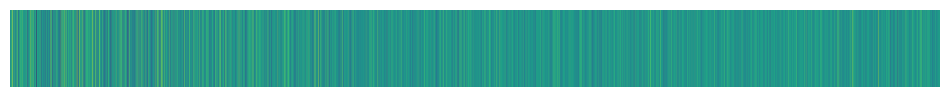

In [14]:
text = "hello world"
emed = llm.call_embed(
    input=text,
    model="text-embedding-3-large"
)

import numpy as np
import matplotlib.pyplot as plt
emed = np.array(emed)
print(f"embedding shape: {emed.shape}")
plt.figure(figsize=(12, 1))
plt.imshow(emed.reshape(1, -1), aspect='auto')
plt.axis('off')
plt.show()


## 4 模版化LLM调用
本节将演示如何自定义模版，并通过 `TemplateLLM` 进行调用。  
以下代码定义了一个 RDF 三元组抽取任务的 prompt模版
你也可以自己定义模版，遵循类似"[text2triples.py](https://github.com/colehank/AI-interface/blob/main/ai_interface/datasets/llm_prompts/text2triples.py)" 的格式。

```python

In [15]:
prompt_file = ai_interface.prompts.llm_prompts['text2triples']
template_llm = TemplateLLM(prompt_file)

Template loaded from
/Users/zgh/Desktop/workingdir/AI-interface/ai_interface/datasets/llm_prompts/text2triples.py


In [27]:
print(template_llm.variables)
template_llm

['passage', 'named_entities']


,Template Info
Name,text2triples.py
Variables to fill,"passage, named_entities"


如上说明了该模版LLM需要在调用的时候提供`passage`, `named_entities`。对于自定义模版，仅需要在`conditioned_frame`用`$`表示需传入的参数即可，工具会自动解析

In [28]:
res = template_llm.call(
    passage='XiaoMing is a Chinese student from BNU',
    named_entities='["Chinese", "BNU", "XiaoMing"]',
    response_format='json',
)
template_llm.print_history()


===================================== ⚙️ =====================================
Your task is to construct an RDF (Resource Description Framework) graph from the given passages and named entity lists.
Respond with a JSON list of triples, with each triple representing a relationship in the RDF graph.

Pay attention to the following requirements:
- Each triple should contain at least one, but preferably two, of the named entities in the list for each passage.
- Clearly resolve pronouns to their specific names to maintain clarity.


===================================== 👤 =====================================

Convert the paragraph into a JSON dict,
it has a named entity list and a triple list.

Paragraph:
Radio City is India's first private FM radio station and was started on 3 July 2001.
It plays Hindi, English and regional songs.
Radio City recently forayed into New Media in May 2008 with the launch of a music portal - PlanetRadiocity.com that offers music related news, videos, songs, a

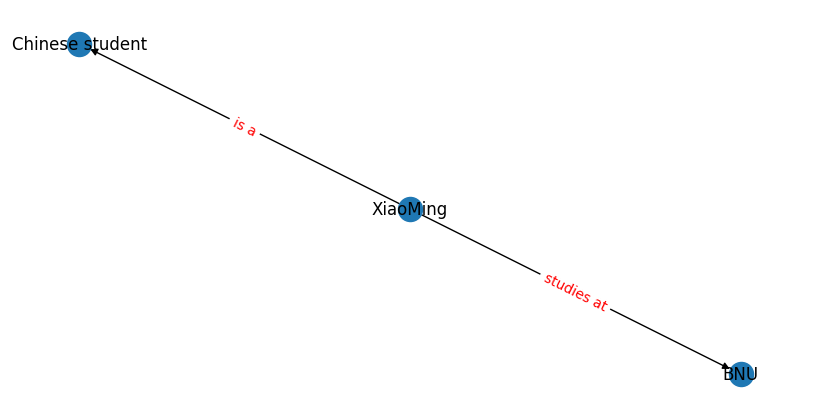

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
for head, relation, tail in res['triples']:
    G.add_edge(head, tail, label=relation)

pos = nx.spring_layout(G)
plt.figure(figsize=(8, 4))
nx.draw(G, pos, with_labels=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.axis('off')
plt.show()